# Using a Regression Neural Network to Predict Housing Prices in Hyderabad

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy
import pandas
import tensorflow
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU

# Setting random seeds to get reproducible results
numpy.random.seed(0)
tensorflow.random.set_seed(1)

In [2]:
# Helpers & Preprocessing Functions

def standardize(matrix):
    """
    Adds a tiny offset to prevent dividing by 0
    """
    offset = 1e-6
    mean = numpy.mean(matrix)
    std = numpy.std(matrix) + offset
    numerator = numpy.subtract(matrix,mean)

    return numpy.divide(numerator, std)

def process_housing(dataframe):
    """
    The columns appear to be categorical, so we won't scale
    The 9's appear to be NAN, so we'll drop those.
    """
    # Find any row with a 9
    mask_has_value = dataframe.iloc[:, :] == 9
    mask_has_value = mask_has_value.any(axis=1)

    return dataframe[~mask_has_value]

def process_features(dataframe):
    """
    Removes Location since it's text
    Standardizes non-categorical columns
    """
    columns_drop = ['Price', 'Location']
    columns_continuous = ['Area'] # 'No. of Bedrooms'

    dataframe_p = (
        dataframe.drop(columns=columns_drop)
    )
    for column in columns_continuous:
        dataframe_p.loc[:, column] = standardize(dataframe_p[column])

    return dataframe_p

## Loading and preprocessing the dataset

The dataset has mostly binary columns (1 or 0), so we'll ignore the text column and scale area columns to help the model. Number of rooms can be treated as a categorical, so we'll leave it intact. Also, some data values are just filled with 9 that don't fit the pattern with the rest of the data. Without the dataset's documentation we can't do anything about it, so we'll drop them.

In [3]:
data_housing_raw = pandas.read_csv('Hyderabad.csv')
data_housing_raw.head()

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
0,6968000,1340,Nizampet,2,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
1,29000000,3498,Hitech City,4,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
2,6590000,1318,Manikonda,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5739000,1295,Alwal,3,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5679000,1145,Kukatpally,2,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [4]:
data_housing_raw.tail()

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
2513,11000000,1460,Nacharam,2,1,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
2514,26000000,1314,Manikonda,2,1,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
2515,13300000,2625,Madhapur,3,1,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
2516,10800000,2050,Hitech City,3,0,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
2517,10400000,1805,Narsingi,3,0,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9


In [5]:
data_housing = process_housing(data_housing_raw)
data_housing.head()

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
0,6968000,1340,Nizampet,2,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
1,29000000,3498,Hitech City,4,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
2,6590000,1318,Manikonda,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5739000,1295,Alwal,3,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5679000,1145,Kukatpally,2,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [6]:
features = process_features(data_housing)
features.head()

C:\Users\akaku\AppData\Local\Temp\ipykernel_17424\1557787899.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.40663006  2.47846953 -0.43604256 ... -0.12453737  1.81267732
 -0.53363861]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe_p.loc[:, column] = standardize(dataframe_p[column])


,Area,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,RainWaterHarvesting,IndoorGames,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
0,-0.406630,2,0,0,1,1,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
1,2.478470,4,0,0,1,1,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
2,-0.436043,2,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,-0.466792,3,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,-0.667332,2,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [7]:
column_label = "Price"
labels = data_housing[column_label].values
labels

array([ 6968000, 29000000,  6590000, ...,  5600000,  7500000,  4600000],
      shape=(2434,))

## Building and training the neural network
We're using LeakyReLu again to prevent the zero ReLu problem. Notice the last layer is a single unit to ensure we're outputting a scalar (price in this context).

Exercise: Check if the model can actually learn the data by passing in a single training point.

In [8]:
# Building the model

num_units_penultimate = 2**7
model = Sequential()
model.add(Dense(features.shape[1], input_shape=(features.shape[1],)))
model.add(LeakyReLU(alpha = 0.01))
model.add(Dropout(.2))
model.add(Dense(2**8))
model.add(LeakyReLU(alpha = 0.01))
model.add(Dropout(.2))
model.add(Dense(num_units_penultimate))
model.add(LeakyReLU(alpha = 0.01))
model.add(Dropout(.2))
model.add(Dense(1)) # predicting number

# Compiling the model. The metrics flag is added for the model to report the root mean squared error at each epoch.
model.compile(
    loss = 'mean_squared_error',
    optimizer='adam',
    metrics=[tensorflow.keras.metrics.RootMeanSquaredError()]
)
model.summary()

c:\Program Files\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Program Files\Python313\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 38)             │         1,482 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 38)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 38)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │         9,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,491 (173.79 KB)

 Trainable params: 44,491 (173.79 KB)

 Non-trainable params: 0 (0.00 B)

## Training the model

Despite our terrible loss, it IS going down :D. However, the error starts to taper off, which implies our model may not be complicated enough. 

In [9]:
history = model.fit(features, labels, epochs=300, batch_size=num_units_penultimate, verbose = 1)

Epoch 1/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 175264898220032.0000 - root_mean_squared_error: 13238765.0000
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 175264327794688.0000 - root_mean_squared_error: 13238743.0000 
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 175261895098368.0000 - root_mean_squared_error: 13238652.0000 
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 175253640708096.0000 - root_mean_squared_error: 13238340.0000 
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 175231494782976.0000 - root_mean_squared_error: 13237503.0000 
Epoch 6/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 175183209955328.0000 - root_mean_squared_error: 13235679.0000 
Epoch 7/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 175091841236992.0000 - root_mean_squared_error: 13232227.0000 
Epoch 8/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 174939286011904.0000 - root_mean_squared_error: 13226462.0000 
Epoch 9/300
20/20 ━━━━━━━

In [10]:
print("Min. Loss:", min(history.history['loss']))
print("Min. Error:", min(history.history['root_mean_squared_error']))

Min. Loss: 32855994400768.0
Min. Error: 5732015.0


In [11]:
model.evaluate(features, labels)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31082357456896.0000 - root_mean_squared_error: 5575155.5000


[31082357456896.0, 5575155.5]

# Visually checking the model's performance

In [12]:
array_predictions = model.predict(features) # The predictions are an array of 1point arrays (see the ravel function)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


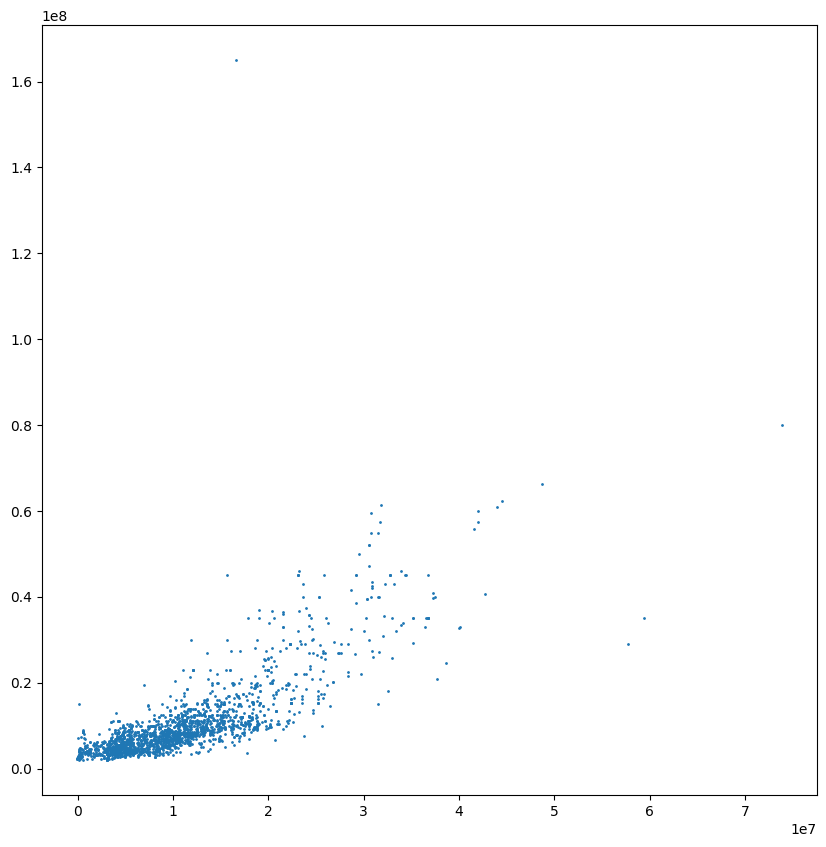

In [13]:
plt.figure(figsize=(10, 10))
plt.scatter(array_predictions.reshape(-1), labels, alpha = 1, s = 1)

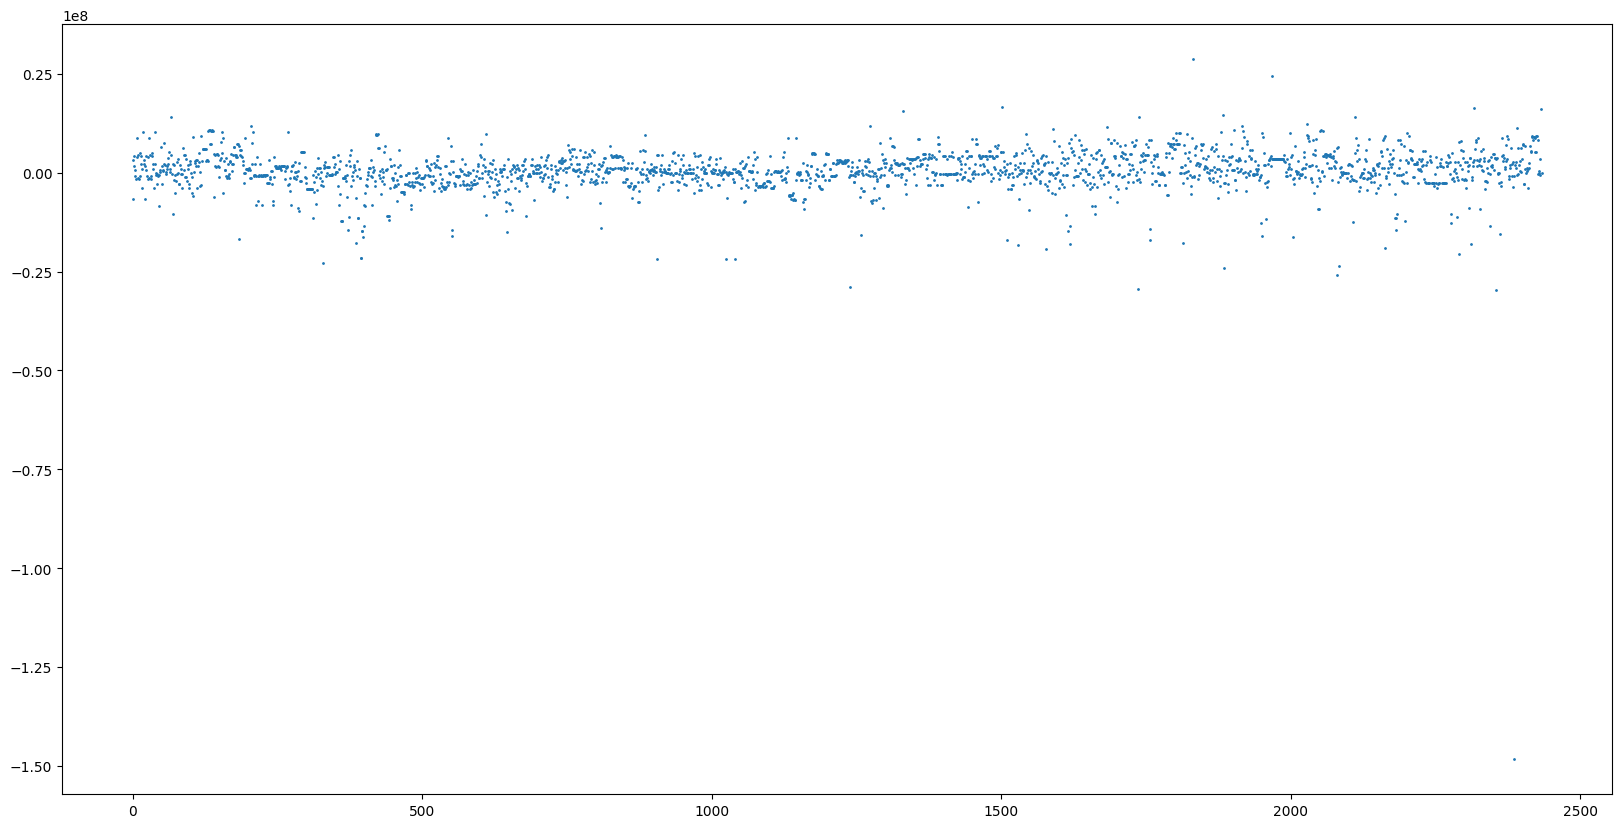

In [14]:
# The array predictions 
residuals = numpy.subtract(array_predictions.reshape(-1), labels)
plt.figure(figsize=(20, 10))
plt.scatter(range(len(residuals)), residuals, alpha = 1, s = 1)